In [ ]:
!git clone https://github.com/Deeachain/Segmentation-Pytorch.git
import sys
sys.path.append('Segmentation-Pytorch')
# %cd 'Segmentation-Pytorch'
from model import *

# Prepare

In [ ]:
!pip install -q torchsummary
!pip install -Uq git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
smp.__version__

In [ ]:
!pip install -q pytorch-lightning
# !pip install -q timm
!pip install -q opencv-python-headless==4.5.2.52
!pip install -Uq albumentations

# import

## Пакеты

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re, os, random, datetime, time, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline 

np.random.seed(2022)
plt.rcParams["savefig.bbox"] = 'tight'
palette = list(sns.color_palette("tab10").as_hex())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as FF
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint 

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 

import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F

from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
import cv2


## def

In [ ]:
from zipfile import ZipFile
def unzip_file(ipath, opath = None):
    # Open your .zip file
    with ZipFile(file = ipath) as zip_file:
        # Loop over each file
        iname = ipath.name
        for file in tqdm(iterable=zip_file.namelist(), desc = iname, total=len(zip_file.namelist())):
            # Extract each file to another directory
            # If you want to extract to current working directory, don't specify path
            expath = (Path(opath) / file)
            if not expath.exists():
                zip_file.extract(member=file, path=opath)            

In [ ]:
def get_mask(mask):
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]
    masks = []
    for num in obj_ids:
        # _ = np.expand_dims(mask[0] == num, axis=0)
        # masks.append(_)
        masks.append(mask[0] == num)
    masks = np.stack(masks)
    masks = torch.tensor(masks)
    return masks

In [ ]:
def see_images(df, rows, cols, resize = (256, 256)):
    num_img = rows * cols
    fig, axs = plt.subplots(rows, cols, figsize=(20, 4*rows))
    ax = axs.flatten()
    imcount = len(df)
    _t = T.Resize((resize[0], resize[1]))
    for i, idx in enumerate(random.sample(range(0, imcount), num_img)):
        row = df.iloc[idx]
        _file = row['name']
        images = read_image(str(DIR_IMAGES / _file ))
        mask   = read_image(str(DIR_MASKS / _file))
        masks  = get_mask(mask)
        img = draw_segmentation_masks(images, masks, colors=palette)
        img = F.to_pil_image(img)
        ax[i].imshow(np.asarray(_t(img)))
        ax[i].set_title(idx)

In [ ]:
def hex_to_rgb(hex_string):
    r_hex = hex_string[1:3]
    g_hex = hex_string[3:5]
    b_hex = hex_string[5:7]
    return int(r_hex, 16), int(g_hex, 16), int(b_hex, 16)

In [ ]:
def img_denorm(img):
    mean = np.asarray([ 0.485, 0.456, 0.406 ])
    std = np.asarray([ 0.229, 0.224, 0.225 ])
    denormalize = T.Normalize((-1 * mean / std), (1.0 / std))
    res = img.squeeze(0)
    res = denormalize(res)
    res = torch.clamp(res, 0, 1)
    return(res)

In [ ]:
def get_file_path(names_list):
    return [list(map( lambda x : str(DIR_IMAGES / x) ,  names_list)), list(map( lambda x : str(DIR_MASKS / x) ,  names_list))]

## Dir

In [ ]:
from pathlib import Path
ROOT = Path('/content')
DIR_HOME = Path('/content/drive/MyDrive/gpass')
DIR_MODEL = DIR_HOME / 'model_gpass'
DIR_MODEL.mkdir(exist_ok=True)
DIR_ZIP = DIR_HOME / 'dataset_ainol'

# FILES

In [ ]:
list_zips = sorted(DIR_ZIP.glob("*.zip"))
for zfile in list_zips:
    unzip_file(zfile, opath = '/content')

512_1024_1.zip:   0%|          | 0/2000 [00:00<?, ?it/s]

512_1024_2.zip:   0%|          | 0/2000 [00:00<?, ?it/s]

512_1024_3.zip:   0%|          | 0/2000 [00:00<?, ?it/s]

512_1024_4.zip:   0%|          | 0/2000 [00:00<?, ?it/s]

512_1024_5.zip:   0%|          | 0/2000 [00:00<?, ?it/s]

512_1024_6.zip:   0%|          | 0/2000 [00:00<?, ?it/s]

512_1024_7.zip:   0%|          | 0/2000 [00:00<?, ?it/s]

512_1024_8.zip:   0%|          | 0/2000 [00:00<?, ?it/s]

512_1024_9.zip:   0%|          | 0/406 [00:00<?, ?it/s]

In [ ]:
DIR_IMAGES = ROOT / "images"
DIR_MASKS = ROOT / "masks"

list_images = sorted(DIR_IMAGES.glob("*.png"))
list_masks = sorted(DIR_MASKS.glob("*.png"))
imcount  = len(list_masks)

len(list_images), len(list_masks)

(8203, 8203)

In [ ]:
l_df_train = 'df_train.csv'
l_df_test = 'df_test.csv'
r_df_train = DIR_HOME / l_df_train
r_df_test = DIR_HOME / l_df_test
if not Path(l_df_train).exists():
    !cp $r_df_train .
if not Path(l_df_test).exists():
    !cp $r_df_test .   
df_train = pd.read_csv(l_df_train)
df_test  = pd.read_csv(l_df_test)

In [ ]:
# df_train.w.value_counts()

In [ ]:
# df_train.h.value_counts()

In [ ]:
# df_test.h.value_counts()

In [ ]:
a, b = 450*16, 464*16
X_train = df_train['name'][:a].values
X_val   = df_train['name'][a:].values
# X_test  = df_train['name'][b:].values

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
# print('Test Size    : ', len(X_test))

Train Size   :  7200
Val Size     :  1003


# DDRNet39

In [ ]:
'''
DDRNet39
'''

import math
import torch
import numpy as np 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from collections import OrderedDict

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                               momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes):
        super(DAPPM, self).__init__()
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )        
        self.compression = nn.Sequential(
                                    BatchNorm2d(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):

        #x = self.downsample(x)
        width = x.shape[-1]
        height = x.shape[-2]        
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear')+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear')+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear')+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear')+x_list[3])))
       
        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out 

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):
        
        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear')

        return out

class DualResNet(nn.Module):

    def __init__(self, block, layers, num_classes=19, planes=64, spp_planes=128, head_planes=128, augment=False):
        super(DualResNet, self).__init__()

        highres_planes = planes * 2
        self.augment = augment

        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=False)
        self.layer1 = self._make_layer(block, planes, planes, layers[0])
        self.layer2 = self._make_layer(block, planes, planes * 2, layers[1], stride=2)
        self.layer3_1 = self._make_layer(block, planes * 2, planes * 4, layers[2] // 2, stride=2)
        self.layer3_2 = self._make_layer(block, planes * 4, planes * 4, layers[2] // 2)
        self.layer4 = self._make_layer(block, planes * 4, planes * 8, layers[3], stride=2)

        self.compression3_1 = nn.Sequential(
                                          nn.Conv2d(planes * 4, highres_planes, kernel_size=1, bias=False),
                                          BatchNorm2d(highres_planes, momentum=bn_mom),
                                          )

        self.compression3_2 = nn.Sequential(
                                          nn.Conv2d(planes * 4, highres_planes, kernel_size=1, bias=False),
                                          BatchNorm2d(highres_planes, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, highres_planes, kernel_size=1, bias=False),
                                          BatchNorm2d(highres_planes, momentum=bn_mom),
                                          )

        self.down3_1 = nn.Sequential(
                                   nn.Conv2d(highres_planes, planes * 4, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 4, momentum=bn_mom),
                                   )

        self.down3_2 = nn.Sequential(
                                   nn.Conv2d(highres_planes, planes * 4, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 4, momentum=bn_mom),
                                   )

        self.down4 = nn.Sequential(
                                   nn.Conv2d(highres_planes, planes * 4, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 4, momentum=bn_mom),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(planes * 4, planes * 8, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 8, momentum=bn_mom),
                                   )

        self.layer3_1_ = self._make_layer(block, planes * 2, highres_planes, layers[2] // 2)

        self.layer3_2_ = self._make_layer(block, highres_planes, highres_planes, layers[2] // 2)

        self.layer4_ = self._make_layer(block, highres_planes, highres_planes, layers[3])

        self.layer5_ = self._make_layer(Bottleneck, highres_planes, highres_planes, 1)

        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 1, stride=2)

        self.spp = DAPPM(planes * 16, spp_planes, planes * 4)

        if self.augment:
            self.seghead_extra = segmenthead(highres_planes, head_planes, num_classes)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)


    def forward(self, x):
        B, C, H, W = x.shape
        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8
        layers = []

        x = self.conv1(x)

        x = self.layer1(x)
        layers.append(x)

        x = self.layer2(self.relu(x))
        layers.append(x)
  
        x = self.layer3_1(self.relu(x))
        layers.append(x)
        x_ = self.layer3_1_(self.relu(layers[1]))
        x = x + self.down3_1(self.relu(x_))
        x_ = x_ + F.interpolate(
                        self.compression3_1(self.relu(layers[2])),
                        size=[height_output, width_output],
                        mode='bilinear')

        x = self.layer3_2(self.relu(x))
        layers.append(x)
        x_ = self.layer3_2_(self.relu(x_))
        x = x + self.down3_2(self.relu(x_))
        x_ = x_ + F.interpolate(
                        self.compression3_2(self.relu(layers[3])),
                        size=[height_output, width_output],
                        mode='bilinear')

        temp = x_

        x = self.layer4(self.relu(x))
        layers.append(x)
        x_ = self.layer4_(self.relu(x_))
        x = x + self.down4(self.relu(x_))
        x_ = x_ + F.interpolate(
                        self.compression4(self.relu(layers[4])),
                        size=[height_output, width_output],
                        mode='bilinear')

        x_ = self.layer5_(self.relu(x_))
        x = F.interpolate(
                        self.spp(self.layer5(self.relu(x))),
                        size=[height_output, width_output],
                        mode='bilinear')

        x_ = self.final_layer(x + x_)

        x_ = F.interpolate(x_, size=[H, W], mode='bilinear')

        if self.augment: 
            x_extra = self.seghead_extra(temp)
            return [x_, x_extra]
        else:
            return x_      

def DDRNet(pretrained=True, num_classes=19):
    model = DualResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, planes=64, spp_planes=128, head_planes=256, augment=False)
    if pretrained:
        checkpoint = torch.load('./DDRNet/DDRNet39_imagenet.pth', map_location='cpu')
        model.load_state_dict(checkpoint, strict = False)
    return model


def get_seg_model(**kwargs):
    model = DDRNet(pretrained=True, num_classes=11)
    return model

import gdown
from pathlib import Path
url    = 'https://drive.google.com/uc?id=122CMx6DZBaRRf-dOHYwuDY9vG0_UQ10i'
output = './DDRNet/DDRNet39_imagenet.pth'
ckpt = Path('./DDRNet')

ckpt.mkdir(exist_ok=True, parents=True)
gdown.download(url, output, quiet=False)

def_model = get_seg_model()

Downloading...
From: https://drive.google.com/uc?id=122CMx6DZBaRRf-dOHYwuDY9vG0_UQ10i
To: /content/DDRNet/DDRNet39_imagenet.pth
100%|██████████| 161M/161M [00:00<00:00, 299MB/s]


In [ ]:
seg_train_target , seg_train_mask = get_file_path(X_train)
seg_val_target   , seg_val_mask   = get_file_path(X_val)

In [ ]:
class RZD_Dataset(Dataset):
    def __init__(self, list_images = None, list_masks = None, names = None, transform=None):
        super().__init__()
        self.list_images = list_images
        self.list_masks  = list_masks
        self.transform   = transform
        self.names_list = names

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, item):
        
        id_image = str(self.list_images[item])
        id_mask  = str(self.list_masks[item])
        
        raw_image = cv2.imread(id_image, 1)
        raw_image = cv2.cvtColor(raw_image ,cv2.COLOR_BGR2RGB)
        raw_mask= cv2.imread(id_mask, 0)
        transformed = self.transform(image=raw_image, mask=raw_mask)
        image = transformed["image"]
        mask = transformed["mask"]
        return {'image':image, "mask":mask.long()}

# Transform

In [ ]:
size_image =(512,1024)

train_transform = A.Compose([
            A.OneOf([
              A.RandomSizedCrop(min_max_height=(size_image[0]//2, size_image[0]), height=size_image[0], width=size_image[1], p=1),
              A.RandomCrop(size_image[0]//2, size_image[0]//2, p=1), 
              ], p=0.35),
            A.Resize(height=size_image[0],width=size_image[1]),
            A.RandomBrightnessContrast(p=0.3, brightness_limit=(-0.25, 0.25), contrast_limit=(-0.25, 0.25)),
            A.HueSaturationValue(p=0.3, hue_shift_limit=0.25, sat_shift_limit=0.25, val_shift_limit=0.25),
            A.RGBShift(p=0.2 ),
            A.ToGray(p=0.2 ),
            A.HorizontalFlip(p=0.5),
            A.OneOf([
                A.MotionBlur(blur_limit=5, p=0.5),
                A.Blur(blur_limit=5, p=0.5),
            ], p=0.15),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

val_transform = A.Compose([
                        A.Resize(size_image[0], size_image[1]),
                        A.HorizontalFlip(p=0.5),  
                        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
                        ToTensorV2(),
                        ])

pred_transform = A.Compose([
                        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
                        ToTensorV2(),
                        ])

train_dataset = RZD_Dataset(list_images = seg_train_target,
                            list_masks  = seg_train_mask,
                            transform   = train_transform
                            )

valid_dataset  = RZD_Dataset(list_images = seg_val_target,
                             list_masks  = seg_val_mask,
                             transform   = val_transform
                             )

## figure.figsize

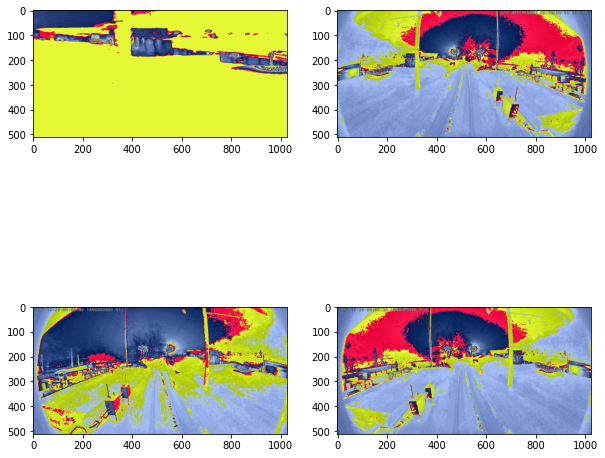

In [ ]:
plt.rcParams["figure.figsize"] = (24,6)
id_image = seg_train_target[2329]
raw_image = cv2.imread(id_image, 1)
raw_image = cv2.cvtColor(raw_image ,cv2.COLOR_BGR2RGB)

def to_tt(raw_image, tt, nrow, ncol  ):
    num = nrow * ncol
    fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(5*ncol, 5*nrow))
    ax = axs.ravel()
    for i in range(num):
        sample = tt(image = raw_image)
        img = T.ToPILImage()(sample['image'])
        ax[i].imshow(img) 
to_tt(raw_image, train_transform, 2, 2  )

In [ ]:
size_image

(512, 1024)

In [ ]:
batch_size = 8
n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)

In [ ]:
len(train_dataloader), len(valid_dataloader)

(900, 126)

# Loss

In [ ]:
def ohem_crossentropy_loss(input: torch.Tensor, target: torch.Tensor, threshold, n_min, ignore_index, class_weight=None):
    b, c, w, h = input.size()
    # threshold = threshold.to(input.device)
    if c == 1:
        target = target.unsqueeze(dim=1)
        loss = F.binary_cross_entropy_with_logits(input, target, reduction="none", pos_weight=class_weight).view(-1)
    else:
        loss = F.cross_entropy(input, target.long(), reduction="none", weight=class_weight, ignore_index=ignore_index).view(-1)
    loss, _ = torch.sort(loss, descending=True)

    if loss[n_min] > threshold:
        loss = loss[loss > threshold]
    else:
        loss = loss[:n_min]

    return loss


class OhemCELoss(nn.Module):
    def __init__(self, threshold, n_min, ignore_index=255, cuda=True, class_weight=None, reduction="mean"):
        super(OhemCELoss, self).__init__()
        self.threshold = -torch.log(torch.tensor(threshold, dtype=torch.float))
        # if cuda:
        #     self.threshold = self.threshold.cuda()
        self.n_min = n_min
        self.ignore_index = ignore_index
        self.class_weight = class_weight
        self.reduction = reduction

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        loss = ohem_crossentropy_loss(input, target, self.threshold, self.n_min, self.ignore_index, self.class_weight)
        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss

In [ ]:
class PolyWarmupAdam(torch.optim.Adam):
    def __init__(self, params, lr, weight_decay, betas, warmup_iter=None, max_iter=None, warmup_ratio=None, power=None):
        super().__init__(params, lr=lr, betas=betas,weight_decay=weight_decay, eps=1e-8)

        self.global_step = 0
        self.warmup_iter = warmup_iter
        self.warmup_ratio = warmup_ratio
        self.max_iter = max_iter
        self.power = power

        self.__init_lr = [group['lr'] for group in self.param_groups]

    def step(self, closure=None):
        ## adjust lr
        if self.global_step < self.warmup_iter:

            lr_mult = 1 - (1 - self.global_step / self.warmup_iter) * (1 - self.warmup_ratio)
            for i in range(len(self.param_groups)):
                self.param_groups[i]['lr'] = self.__init_lr[i] * lr_mult

        elif self.global_step < self.max_iter: 

            lr_mult = (1 - self.global_step / self.max_iter) ** self.power
            for i in range(len(self.param_groups)):
                self.param_groups[i]['lr'] = self.__init_lr[i] * lr_mult

        # step
        super().step(closure)

        self.global_step += 1

## ClassModel

In [ ]:
class PetModel(pl.LightningModule):
    def __init__(self, model, num_classes,  learning_rate = 0.001,  **kwargs):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.batch_size = 8

        self.loss_OhemCELoss =  OhemCELoss(threshold = 0.7, n_min = 50000 * self.batch_size , class_weight = None)

        self.save_hyperparameters(ignore=['model'])

    def forward(self, image):

        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]
        mask = batch["mask"]
        logits_mask = self.forward(image)


        loss = self.loss_OhemCELoss(logits_mask, mask)

        output = torch.argmax(FF.softmax(logits_mask, dim=1), dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(output, mask,  mode='multiclass', num_classes = self.num_classes)
        return {
            "loss": loss,
            f"loss/{stage}": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,

        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        epoch_loss = [x[f'loss'] for x in outputs]

        
        epoch_loss = torch.FloatTensor(epoch_loss).mean()

        wise_iou_micro = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        wise_iou_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        
        iou_micro = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        iou_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")

        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall   = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision= smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"loss/{stage}": epoch_loss,
            f"iou_micro/{stage}": iou_micro,
            f"iou_macro/{stage}": iou_macro,

            f"wise_iou_micro/{stage}": wise_iou_micro,
            f"wise_iou_macro/{stage}": wise_iou_macro,

            f"f1_score/{stage}": f1_score,
            f"f2_score/{stage}": f2_score,

            f"accuracy/{stage}": accuracy,

            f"recall/{stage}": recall,
            f"precision/{stage}": precision,

        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        """
        Return whatever optimizers and learning rate schedulers you want here.
        At least one optimizer is required.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=5e-4)

        lr_scheduler = {'scheduler':torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min = 0.000001)}

        # lr_scheduler = {'scheduler':PolyLR(optimizer,
        #                    max_iter=max_iter,
        #                    cur_iter=cur_iter,
        #                    power=0.9) }
        # lr_scheduler = {'scheduler': torch.optim.lr_scheduler.OneCycleLR(
        #                                 optimizer,
        #                                 max_lr=self.learning_rate,
        #                                 # steps_per_epoch=int(len(self.train_dataloader())),
        #                                 steps_per_epoch= 393,
        #                                 # epochs=self.hparams.epochs,
        #                                 epochs = 30,
        #                                 anneal_strategy="linear",
        #                                 final_div_factor = 30,
        #                             ),
        #                 'name': 'learning_rate',
        #                 'interval':'step',
        #                 'frequency': 1}

        return [optimizer], [lr_scheduler]



# Train

In [ ]:
model = PetModel(def_model,  num_classes=4)

DIR_LOG = DIR_MODEL
DIR_LOG.mkdir(exist_ok= True)

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
logger   = TensorBoardLogger(save_dir=DIR_LOG)
logger_csv = CSVLogger(save_dir = './log_csv')

lr_loger = pl.callbacks.LearningRateMonitor()

checkpoint_callback = ModelCheckpoint(monitor='loss/valid',
                                    dirpath=DIR_LOG,
                                    mode='min',
                                    auto_insert_metric_name=False,
                                    filename='DDRNet39_' + f'{size_image[1]}' + '_loss_{loss/valid:.2f}-miou_{iou_micro/valid:.2f}-pre_{precision/valid:.2f}-e_{epoch:02d}',
                                    save_top_k=2)
earlyStopping = pl.callbacks.EarlyStopping(monitor="loss/valid", mode="min", patience=5)

In [ ]:
trainer = pl.Trainer(
    precision=16,
    gpus=-1, 
    max_epochs=40,
    log_every_n_steps=10,
    logger=[logger, logger_csv],
    callbacks=[checkpoint_callback, lr_loger ],
)



Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
    )

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1bi5xL3iaEtcYvTPm7fG3qP1K8UzowtEQ/gpass/model_gpass exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type        | Params
------------------------------------------------
0 | model           | DualResNet  | 32.4 M
1 | loss_fn2        | JaccardLoss | 0     
2 | loss_OhemCELoss | OhemCELoss  | 0     
------------------------------------------------
32.4 M    Trainable params
0         Non-trainable params
32.4 M    Total params
64.716    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]